In [1]:
import gensim
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split

pd.set_option('display.max_colwidth', 100)

messages = pd.read_csv("data/spam.csv", encoding='latin-1')
messages = messages.drop(labels = ["Unnamed: 2", "Unnamed: 3", "Unnamed: 4"], axis=1)
messages.columns = ['label', 'text']
labels = np.where(messages['label']=='spam',1,0)
messages.head()

,label,text
0,ham,"Go until jurong point, crazy.. Available only in bugis n great world la e buffet... Cine there g..."
1,ham,Ok lar... Joking wif u oni...
2,spam,Free entry in 2 a wkly comp to win FA Cup final tkts 21st May 2005. Text FA to 87121 to receive ...
3,ham,U dun say so early hor... U c already then say...
4,ham,"Nah I don't think he goes to usf, he lives around here though"


In [2]:
X_train, X_test, y_train, y_test = train_test_split(messages['text'],labels, test_size=0.2, random_state=42)

In [3]:
print(X_train.shape)
print(X_test.shape)


(4457,)
(1115,)


In [4]:
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences

In [5]:
tokenizer = Tokenizer()
tokenizer.fit_on_texts(X_train)

In [6]:
X_train_seq = tokenizer.texts_to_sequences(X_train)
X_test_seq = tokenizer.texts_to_sequences(X_test)

In [7]:
# convert the word into a sequence of vector - each interger is a word
X_train_seq[0]

[38,
 30,
 8,
 5,
 273,
 1989,
 81,
 116,
 26,
 11,
 1656,
 322,
 10,
 53,
 18,
 299,
 30,
 349,
 1990]

In [8]:
# pad the sequences so each sequence is the same length
X_train_seq_padded = pad_sequences(X_train_seq, 50)
X_test_seq_padded = pad_sequences(X_test_seq, 50)

In [9]:
X_train_seq_padded

array([[   0,    0,    0, ...,   30,  349, 1990],
       [   0,    0,    0, ...,  203, 1025,  225],
       [   0,    0,    0, ...,    2, 3794, 3795],
       ...,
       [   0,    0,    0, ...,  239,   30, 2064],
       [   0,    0,    0, ..., 1161,    1,  255],
       [   0,    0,    0, ...,    8,  290,  175]])

In [10]:
# Import the tools needed from keras and define functions to calculate recall and precision
import keras.backend as K
from keras.layers import Dense, Embedding, LSTM
from keras.models import Sequential

def recall_m(y_true, y_pred):
        true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
        possible_positives = K.sum(K.round(K.clip(y_true, 0, 1)))
        recall = true_positives / (possible_positives + K.epsilon())
        return recall

def precision_m(y_true, y_pred):
        true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
        predicted_positives = K.sum(K.round(K.clip(y_pred, 0, 1)))
        precision = true_positives / (predicted_positives + K.epsilon())
        return precision

In [11]:
# Construct a simple RNN model
model = Sequential()

model.add(Embedding(len(tokenizer.index_word)+1, 32))
model.add(LSTM(32, dropout=0, recurrent_dropout=0))
model.add(Dense(32, activation='relu'))
model.add(Dense(1, activation='sigmoid'))
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, None, 32)          254560    
                                                                 
 lstm (LSTM)                 (None, 32)                8320      
                                                                 
 dense (Dense)               (None, 32)                1056      
                                                                 
 dense_1 (Dense)             (None, 1)                 33        
                                                                 
Total params: 263969 (1.01 MB)
Trainable params: 263969 (1.01 MB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [12]:
# Compile the model
model.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy', precision_m, recall_m])

In [13]:
# Fit the RNN model
history = model.fit(X_train_seq_padded, y_train, 
                    batch_size=32, epochs=10,
                    validation_data=(X_test_seq_padded, y_test))

Epoch 1/10
140/140 [==============================] - 11s 39ms/step - loss: 0.2563 - accuracy: 0.9154 - precision_m: 0.4964 - recall_m: 0.4026 - val_loss: 0.0772 - val_accuracy: 0.9767 - val_precision_m: 0.9386 - val_recall_m: 0.8942
Epoch 2/10
140/140 [==============================] - 4s 25ms/step - loss: 0.0300 - accuracy: 0.9912 - precision_m: 0.9729 - recall_m: 0.9501 - val_loss: 0.0562 - val_accuracy: 0.9821 - val_precision_m: 0.9952 - val_recall_m: 0.8752
Epoch 3/10
140/140 [==============================] - 4s 26ms/step - loss: 0.0068 - accuracy: 0.9984 - precision_m: 0.9771 - recall_m: 0.9707 - val_loss: 0.0824 - val_accuracy: 0.9821 - val_precision_m: 0.9952 - val_recall_m: 0.8692
Epoch 4/10
140/140 [==============================] - 4s 29ms/step - loss: 0.0019 - accuracy: 0.9998 - precision_m: 0.9929 - recall_m: 0.9918 - val_loss: 0.0557 - val_accuracy: 0.9857 - val_precision_m: 0.9952 - val_recall_m: 0.8987
Epoch 5/10
140/140 [==============================] - 5s 33ms/step 

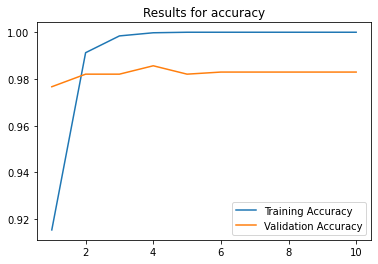

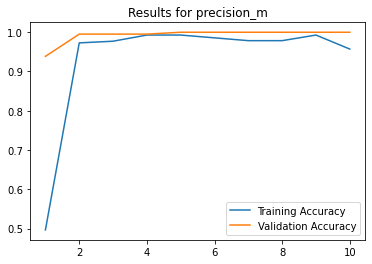

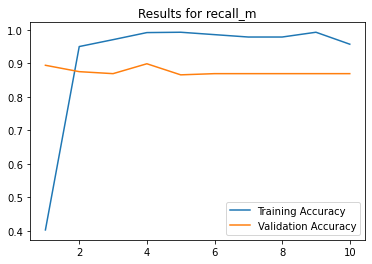

In [14]:
# Plot the evaluation metrics by each epoch for the model to see if we are over or underfitting
import matplotlib.pyplot as plt

for i in ['accuracy', 'precision_m', 'recall_m']:
    acc = history.history[i]
    val_acc = history.history['val_{}'.format(i)]
    epochs = range(1, len(acc) + 1)

    plt.figure()
    plt.plot(epochs, acc, label='Training Accuracy')
    plt.plot(epochs, val_acc, label='Validation Accuracy')
    plt.title('Results for {}'.format(i))
    plt.legend()
    plt.show()